In [1]:
import re

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import NMF
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.pipeline import Pipeline

## Dataset

In [2]:
df = pd.read_csv("data/labeled_data.csv").drop(columns=["Unnamed: 0"])
df.head(5)

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


### Colunas:

count = número de usuários do CrowdFlower que codificaram cada tweet (o mínimo é 3, às vezes mais usuários codificaram um tweet quando os julgamentos foram considerados pouco confiáveis pelo CF).

hate_speech = número de usuários do CF que julgaram o tweet como discurso de ódio.

offensive_language = número de usuários do CF que julgaram o tweet como linguagem ofensiva.

neither = número de usuários do CF que julgaram o tweet como nem ofensivo nem não ofensivo.

class = rótulo de classe para a maioria dos usuários do CF.

    0 - discurso de ódio
    1 - linguagem ofensiva
    2 - nenhum dos dois

tweet = texto bruto do tweet


<Axes: >

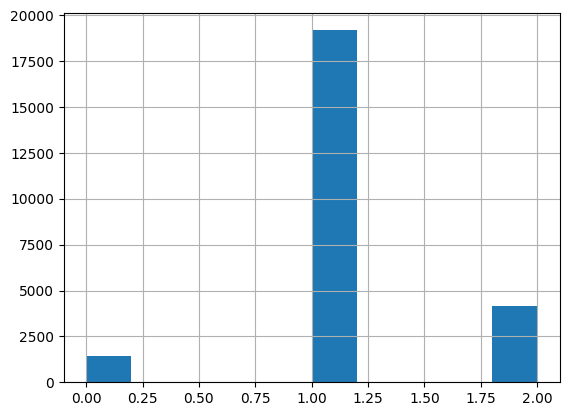

In [3]:
df["class"].hist()


Pelo histograma acima, é possível perceber que a quantidade de tweets com linguagem ofensiva é maior que a quantidade de tweets com discurso de ódio e com nenhum dos dois. Portanto o dataset está desbalanceado.

## Pré-Processamento

In [4]:
X = df["tweet"]
y = df["class"]

Remove urls, menções, urls, caracteres especiais, "RT" e números.

In [5]:
url_regex = (r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        r'[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')

username_regex = '@[A-Za-z0-9_]+'

special_chars_regex = '[^A-Za-z]+'

X = X.apply(lambda x: re.sub(url_regex, '', x))
X = X.apply(lambda x: re.sub(username_regex, '', x))
X = X.apply(lambda x: re.sub(special_chars_regex, ' ', x))
X = X.apply(lambda x: x.lower())
X = X.apply(lambda x: x.replace('rt', ''))

Remove stopwords.

In [6]:
stop_words = set(stopwords.words('english'))

X = X.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
X = X.apply(lambda x: x.replace('rt', ''))

Realiza a lematização das palavras.

In [7]:
lemmatizer = WordNetLemmatizer()

X = X.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

Utilizando o TfidfVectorizer para vetorizar o texto.

In [8]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(X)
tfidf.shape

(24783, 18050)

In [9]:
feature_names = vectorizer.get_feature_names_out()

## Classificador

### Regressão Logística

In [13]:
accuracies_LR = []

model_lr = LogisticRegression(class_weight='balanced')

shuffle_split = ShuffleSplit(n_splits=30, test_size=0.2)

importance_accumulator_LR = np.zeros(len(feature_names))

for train_index, test_index in shuffle_split.split(tfidf):
    X_train, X_test = tfidf[train_index], tfidf[test_index]
    y_train, y_test = y[train_index], y[test_index]

    
    model_lr.fit(X_train, y_train)

    importance_accumulator_LR += np.abs(model_lr.coef_[0])

    y_pred = model_lr.predict(X_test)

    accuracy = balanced_accuracy_score(y_test, y_pred)
    accuracies_LR.append(accuracy)

mean_accuracy_lr = sum(accuracies_LR) / len(accuracies_LR)
print(f"A média da acurácia do Logistic Regression é {mean_accuracy_lr:.2f}")

A média da acurácia do Logistic Regression é 0.80


In [14]:
average_importance = importance_accumulator_LR / shuffle_split.get_n_splits()
sorted_importance = np.argsort(average_importance)[::-1]
top_10 = sorted_importance[:10]

print("Top 10 features:")
for index in top_10:
    print(feature_names[index])

Top 10 features:
faggot
nigger
nigga
fag
white
queer
dyke
fuck
wetback
coon


### Random Forest

In [26]:
accuracies_RF = []

model_RF = RandomForestClassifier(n_jobs=-1, class_weight="balanced_subsample", min_samples_leaf=2)

shuffle_split = ShuffleSplit(n_splits=30, test_size=0.2)

importance_accumulator_RF = np.zeros(len(feature_names))

count = 0

for train_index, test_index in shuffle_split.split(tfidf):
    X_train, X_test = tfidf[train_index], tfidf[test_index]
    y_train, y_test = y[train_index], y[test_index]

    
    model_RF.fit(X_train, y_train)

    importance_accumulator_RF += model_RF.feature_importances_

    y_pred = model_RF.predict(X_test)

    accuracy = balanced_accuracy_score(y_test, y_pred)
    accuracies_RF.append(accuracy)

    count += 1
    print(f"count: {count}/30 accuracy:{accuracy}", end="\r")
    

mean_accuracy_RF = sum(accuracies_RF) / len(accuracies_RF)
print(f"A média da acurácia do Random Forest é {mean_accuracy_RF:.2f}")

A média da acurácia do Random Forest é 0.81


In [19]:
average_importance = importance_accumulator_RF / shuffle_split.get_n_splits()
sorted_importance = np.argsort(average_importance)[::-1]
top_10 = sorted_importance[:10]

print("Top 10 features:")
for index in top_10:
    print(feature_names[index])

Top 10 features:
bitch
hoe
faggot
pussy
nigger
nigga
fag
trash
bird
fuck


## Dataset Size

In [22]:
df_data = pd.DataFrame({"tweet": X, "class": y})

In [23]:
dict_f_accuracy = {}

model = Pipeline([
            ('vectorizer', TfidfVectorizer()),
            ('classifier', LogisticRegression(class_weight='balanced'))
        ])


for f in np.arange(0.01, 0.9, 0.01):
    train_accuracies = []
    test_accuracies = []
    

    for _ in range(10):
        data_resampled = df.sample(frac=f)
        target_resampled = data_resampled["class"]

        X_train, X_test, y_train, y_test = train_test_split(data_resampled["tweet"], target_resampled, test_size=0.2, random_state=42)

        model.fit(X_train, y_train)

        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        train_accuracies.append(balanced_accuracy_score(y_train, y_pred_train))
        test_accuracies.append(balanced_accuracy_score(y_test, y_pred_test))

    dict_f_accuracy[f] = {'train': np.mean(train_accuracies), 'test': np.mean(test_accuracies)}

In [35]:
df_f_accuracy = pd.DataFrame(dict_f_accuracy).T
df_f_accuracy["train"] = 1 - df_f_accuracy["train"]
df_f_accuracy["test"] = 1 - df_f_accuracy["test"]

In [36]:
df_f_accuracy.index = df_f_accuracy.index * len(df)
df_f_accuracy["test"] = df_f_accuracy["test"].rolling(window=5).mean()

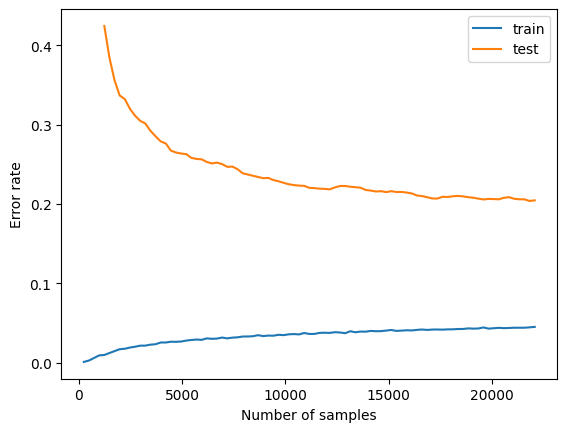

In [40]:
df_f_accuracy.plot()
plt.xlabel("Number of samples")
plt.ylabel("Error rate")
plt.show()

## Topic Models

In [10]:
corpus = X

vectorizer_nmf_pipeline = Pipeline([('vectorizer', CountVectorizer(binary=True)),
                                ('nmf', NMF(n_components=3, random_state=42))])
X_nmf = vectorizer_nmf_pipeline.fit_transform(corpus)
X_nmf.shape

(24783, 3)

In [11]:
def print_words_in_topics(nmf, vectorizer):
    words = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(nmf.components_):
        print(f"Topic {idx}")
        for i in topic.argsort()[-5:]:
            print(words[i])
        print()
    print()
    
print_words_in_topics(vectorizer_nmf_pipeline.named_steps['nmf'], vectorizer_nmf_pipeline.named_steps['vectorizer'])

Topic 0
get
fuck
as
nigga
bitch

Topic 1
get
as
got
nigga
hoe

Topic 2
get
look
nigga
pussy
like




In [12]:
num_iterations = 10
accuracies = []
accuracies_by_topic = {i: [] for i in range(3)}  

for _ in range(num_iterations):
    X_train, X_test, y_train, y_test = train_test_split(corpus, y, test_size=0.2, random_state=42)

    topic_pipeline = Pipeline([
        ('vectorizer', CountVectorizer()),
        ('nmf', NMF(n_components=3, random_state=42))
    ])

    X_topic_train = topic_pipeline.fit_transform(X_train)
    X_topic_test = topic_pipeline.transform(X_test)
    prominent_topics = np.argmax(X_topic_test, axis=1)

    classification_pipeline = Pipeline([
        ('vectorizer', CountVectorizer()),
        ('classifier', LogisticRegression(class_weight='balanced'))
    ])

    classification_pipeline.fit(X_train, y_train)
    y_pred = classification_pipeline.predict(X_test)

    accuracy_by_topic = {}
    for topic in np.unique(prominent_topics):
        topic_indices = np.where(prominent_topics == topic)
        accuracy_by_topic[topic] = balanced_accuracy_score(y_test.iloc[topic_indices], y_pred[topic_indices])
        accuracies_by_topic[topic].append(accuracy_by_topic[topic])

    accuracies.append(np.mean(list(accuracy_by_topic.values())))

mean_accuracy = np.mean(accuracies)
print(f"Média da acurácia por tópico após {num_iterations} iterações: {mean_accuracy:.2f}")

for topic, acc_list in accuracies_by_topic.items():
    if acc_list:  
        mean_topic_accuracy = np.mean(acc_list)
        print(f"Média da acurácia para o tópico {topic}: {mean_topic_accuracy:.2f}")

Média da acurácia por tópico após 10 iterações: 0.67
Média da acurácia para o tópico 0: 0.58
Média da acurácia para o tópico 1: 0.67
Média da acurácia para o tópico 2: 0.76
